# Integrating v2

In [1]:
%load_ext autoreload
%autoreload 2

In [56]:
import os
import subprocess
import yaml

from astropy.io import fits
import numpy as np
import pandas as pd
import glob
from tqdm import tqdm
import random

from scipy.interpolate import interp2d, RectBivariateSpline
from matplotlib import pyplot as plt

In [4]:
from gravitational_wave_toy import GWToyV2 as gwt

/Users/jarred/Documents/Projects/gravitational_wave_toy/.venv/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


## Import a sample grb

In [5]:
filepath = "./GammaCatalogV2.0/run0639_ID000222.fits"

In [235]:
grb = gwt.GRB(filepath)

In [289]:
time_index = 50
energy_index = 10
print(f"Spectrum at t={grb.time[time_index]}s:")
print(np.array(grb.lc[time_index]))
print()
print(f"Value at {grb.energy[energy_index]} GeV:")
print(np.array(grb.lc[time_index])[energy_index])
print()
print(f"Lightcurve at energy {grb.energy[energy_index]} GeV:")
print(grb.lc.field(10))
print()
print(f"LC value at t={grb.time[time_index]}s:")
print(grb.lc.field(10)[time_index])

Spectrum at t=10000.0s:
[8.63502424e-18 5.27549920e-18 3.22302414e-18 1.96908039e-18
 1.20299344e-18 7.34959249e-19 4.49017492e-19 2.74323656e-19
 1.67595839e-19 1.02391059e-19 6.25542882e-20 3.82155421e-20
 2.33474807e-20 1.42639571e-20 8.71444111e-21 5.32392314e-21
 3.25222328e-21 1.98523708e-21 1.21286476e-21 7.40985362e-22
 4.52678923e-22 2.76444973e-22 1.68380404e-22 1.02708634e-22
 6.27439278e-23 3.83145104e-23 2.33234840e-23 1.40566756e-23
 8.58121812e-24 5.22333427e-24 3.07889038e-24 1.87396066e-24
 1.11737198e-24 6.55875186e-25 3.75313085e-25 2.20153637e-25
 1.22507256e-25 6.47949218e-26 2.60612051e-26 4.39645129e-27
 0.00000000e+00]

Value at 10.0 GeV:
6.255428820326217e-20

Lightcurve at energy 10.0 GeV:
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.77748540e-27 1.59431806e-26 

In [296]:
grb.get_lightcurve(energy=10)

array([ 1.48468592e-49, -8.57677536e-49,  2.83674822e-48, -7.87484184e-48,
        2.10621376e-47, -5.60769423e-47,  1.49287273e-46, -3.97846373e-46,
        1.05927011e-45, -2.81764994e-45,  7.46766184e-45, -1.98371314e-44,
        5.29865982e-44, -1.42582119e-43,  3.89560973e-43, -1.23314265e-42,
        5.77748540e-27,  1.59431806e-26,  3.56370279e-26,  6.49518841e-26,
        1.12733168e-25,  1.90125986e-25,  3.02651059e-25,  4.67179983e-25,
        7.17603785e-25,  1.11239107e-24,  1.74451275e-24,  2.70119487e-24,
        4.16377708e-24,  6.39565046e-24,  9.91419588e-24,  1.55479862e-23,
        2.40744246e-23,  3.71097023e-23,  5.70012948e-23,  8.83603638e-23,
        1.38571573e-22,  2.14563535e-22,  3.30740570e-22,  5.08024574e-22,
        7.87512571e-22,  1.23502045e-21,  1.91229952e-21,  2.94772843e-21,
        4.52777378e-21,  7.01871317e-21,  1.10071313e-20,  1.70433872e-20,
        2.62716558e-20,  4.03538175e-20,  6.25542882e-20,  9.81007526e-20,
        1.51896850e-19,  

In [281]:
grb.get_spectrum(time=2.5)

[1.0795650218133582e-27,
 6.595516404439192e-28,
 4.0294781486295275e-28,
 2.4617776969537166e-28,
 1.504003699936573e-28,
 9.188590659046855e-29,
 5.613696183266511e-29,
 3.429642913409602e-29,
 2.0953129918044504e-29,
 1.2801141922118306e-29,
 7.820797069820316e-30,
 4.777880480030704e-30,
 2.9190079752267282e-30,
 1.783344643100568e-30,
 1.0895202470400104e-30,
 6.656320880546478e-31,
 4.066811192647157e-31,
 2.481416869396856e-31,
 1.5160018468241531e-31,
 9.261887522479381e-32,
 5.658439215936143e-32,
 3.456286952321224e-32,
 2.0907165506891694e-32,
 1.2669965766282003e-32,
 7.740519272293967e-33,
 4.729982342619433e-33,
 2.8623191498030298e-33,
 1.6390339617543527e-33,
 1.0016937907853615e-33,
 6.0848245223796335e-34,
 3.0974550558112413e-34,
 1.8851771038467183e-34,
 1.016347709455294e-34,
 4.85480429797648e-35,
 1.6813379340803876e-35,
 7.162825798379051e-36,
 -3.7998604550471205e-36,
 -7.038842543183004e-37,
 3.7594585167584404e-37,
 5.943491187042372e-39,
 0.0]

In [263]:
[ i[0] for i in grb.get_spectrum(10000)(grb.energy) ]

OK2


[8.635024243057115e-18,
 5.275499196162016e-18,
 3.2230241426376792e-18,
 1.9690803863891188e-18,
 1.2029934411963554e-18,
 7.349592489126227e-19,
 4.490174917537552e-19,
 2.7432365563006103e-19,
 1.675958388498435e-19,
 1.0239105940916851e-19,
 6.255428820326218e-20,
 3.821554211446624e-20,
 2.3347480682276223e-20,
 1.4263957124473537e-20,
 8.714441109470907e-21,
 5.3239231413388244e-21,
 3.2522232778986624e-21,
 1.9852370838713978e-21,
 1.2128647639380246e-21,
 7.409853618727054e-22,
 4.526789233698462e-22,
 2.7644497340906085e-22,
 1.6838040402805863e-22,
 1.0270863403890972e-22,
 6.274392778670068e-23,
 3.831451036445969e-23,
 2.33234840367218e-23,
 1.4056675563369916e-23,
 8.581218120636172e-24,
 5.223334269021948e-24,
 3.0788903836856427e-24,
 1.8739606598765672e-24,
 1.11737197567468e-24,
 6.558751864964922e-25,
 3.7531308462308093e-25,
 2.201536373956032e-25,
 1.2250725578146778e-25,
 6.479492180983373e-26,
 2.6061205139868023e-26,
 4.396451293008555e-27,
 0.0]

In [102]:
%time
f = RectBivariateSpline(grb.energy, grb.time, grb.spectra)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


In [103]:
%time
f2 = interp2d(grb.time, grb.energy, grb.spectra, kind="linear")

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


ValueError: x and y must have same first dimension, but have shapes (100,) and (1,)

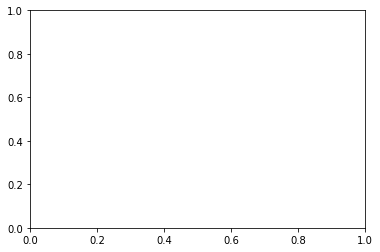

In [147]:
x = np.linspace(1, 1000000, 100)
plt.plot(x, f(x, 1)[0])

In [125]:
f(1, 10)

array([[1.55617664e-23]])

In [79]:
grb.time

array([1.0000000e-01, 1.2589253e-01, 1.5848932e-01, 1.9952624e-01,
       2.5118864e-01, 3.1622776e-01, 3.9810717e-01, 5.0118721e-01,
       6.3095737e-01, 7.9432821e-01, 1.0000000e+00, 1.2589254e+00,
       1.5848932e+00, 1.9952623e+00, 2.5118864e+00, 3.1622777e+00,
       3.9810717e+00, 5.0118723e+00, 6.3095737e+00, 7.9432821e+00,
       1.0000000e+01, 1.2589254e+01, 1.5848932e+01, 1.9952623e+01,
       2.5118864e+01, 3.1622776e+01, 3.9810719e+01, 5.0118725e+01,
       6.3095734e+01, 7.9432823e+01, 1.0000000e+02, 1.2589254e+02,
       1.5848932e+02, 1.9952623e+02, 2.5118864e+02, 3.1622775e+02,
       3.9810718e+02, 5.0118723e+02, 6.3095734e+02, 7.9432825e+02,
       1.0000000e+03, 1.2589254e+03, 1.5848932e+03, 1.9952623e+03,
       2.5118865e+03, 3.1622776e+03, 3.9810718e+03, 5.0118726e+03,
       6.3095732e+03, 7.9432822e+03, 1.0000000e+04, 1.2589254e+04,
       1.5848932e+04, 1.9952623e+04, 2.5118865e+04, 3.1622777e+04,
       3.9810719e+04, 5.0118723e+04, 6.3095734e+04, 7.9432820e